In [1]:
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt

from keras import optimizers, regularizers, applications
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

#from lib import telegram_bot as bot
#from lib.keras_inceptionV4 import inception_v4

plt.style.use('ggplot')
plt.switch_backend('agg')

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
EPOCHS = 60
N_VAL = 6300
N_TRAIN = 14633
BATCH_SIZE = 64
RESOLUTION = 224
EXP_NAME = 'e002'
DATA_FOLDER = './data/bags'
PATH_TRAIN = '../input/simpson-splited/dataset/dataset/train'
PATH_VAL = '../input/simpson-splited/dataset/dataset/valid'

In [4]:
path_wheigths_VGG16 = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
path_wheigths_Inception = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [5]:
def overfitting_plot(history, name):
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Treino acc')
    plt.plot(epochs, val_acc, 'b', label='Validação acc')
    plt.title('Acurácia de Treino e Validação')
    plt.legend(loc='best')
    #plt.savefig('./data/bags/plots/acc/'+'acc_'+name+'.png')
    #plt.show()
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Treino loss')
    plt.plot(epochs, val_loss, 'b', label='Validação loss')
    plt.title('loss de Treino e Validação')
    plt.legend(loc='best')
    
    #plt.savefig('./data/bags/plots/loss/'+'loss_'+name+'.png')
    
    plt.show()

In [6]:
def train(model, path_train, path_val, with_data_augmentation=False, name=' '):
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    if with_data_augmentation:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,)
    
    train_generator = train_datagen.flow_from_directory(
        path_train,
        target_size=(RESOLUTION, RESOLUTION),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    
    val_generator = val_datagen.flow_from_directory(
        path_val,
        target_size=(RESOLUTION, RESOLUTION),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=(N_TRAIN // BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=val_generator ,
        validation_steps=(N_VAL // BATCH_SIZE) 
    )
    
    #model.save('./data/bags/sample/models/'+name+'.h5')
    return model, history
    #overfitting_plot(history, name)

In [7]:
def model_base(freeze_conv=True, name=' '):
    if(name == 'VGG16'):
        model = applications.VGG16(include_top=False,input_shape=(RESOLUTION,RESOLUTION,3), weights=path_wheigths_VGG16)
    elif(name == 'InceptionV3'):
        model = applications.InceptionV3(include_top=False,input_shape=(RESOLUTION,RESOLUTION,3), weights=path_wheigths_Inception)
    elif(name == 'InceptionV4'):
        model = inception_v4.create_model(include_top=False, input_shape=(RESOLUTION,RESOLUTION,3), weights='imagenet')
    
    if(freeze_conv):
        model.trainable = False
    else:
        model.trainable = True
    return model

# models

In [8]:
def vgg16_pretrained_model(dropout_=False, regularizer_=False, regularizer_weight=0.001):
    model_b = model_base(name='VGG16')
    
    model = Sequential()
    model.add(model_b)
    model.add(Flatten())
    if dropout_:
        model.add(Dropout(0.5))
    if regularizer_:
        model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=regularizer_weight,
                                                                                            l2=regularizer_weight)))
    else:
        model.add(Dense(256, activation='relu'))
    model.add(Dense(42, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

    return model

def inceptionV3_pretrained_model(dropout_=False, regularizer_=False, regularizer_weight=0.001):
    model_b = model_base(name='InceptionV3')
    
    model = Sequential()
    model.add(model_b)
    model.add(Flatten())
    if dropout_:
        model.add(Dropout(0.5))
    if regularizer_:
        model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=regularizer_weight,
                                                                                            l2=regularizer_weight)))
    else:
        model.add(Dense(256, activation='relu'))
    model.add(Dense(42, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

    return model


# Fine Tunning

In [9]:
def build_vgg16_pretrained_fine_tunning(first_trainable_layer='block5_conv1',
                                       with_dropout=False,
                                       with_regularizer=False,
                                       regularizer_weight=0.001):
    conv_base = model_base(name='VGG16',freeze_conv=False)
    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == first_trainable_layer:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    if with_dropout:
        model.add(Dropout(0.5))
    if with_regularizer:
        model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=regularizer_weight,
                                                                                            l2=regularizer_weight)))
    else:
        model.add(Dense(256, activation='relu'))
    model.add(Dense(42, activation='softmax')) # for multiclass single-label classification
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc']) # low learn. rate
    
    return model

def build_inceptionV3_pretrained_fine_tunning(first_trainable_layer=249,
                                       with_dropout=False,
                                       with_regularizer=False,
                                       regularizer_weight=0.001):
    # create the base pre-trained model
    base_model = model_base(name='InceptionV3',freeze_conv=False)
    
    for layer in base_model.layers[:first_trainable_layer]:
        layer.trainable = False
    for layer in base_model.layers[first_trainable_layer:]:
        layer.trainable = True
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # let's add a fully-connected layer
    if with_dropout:
        x = Dropout(0.5)(x)
    if with_regularizer:
        x = Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=regularizer_weight,
                                                                                l2=regularizer_weight))(x)
    else:
        x = Dense(256, activation='relu')(x)
    
    # and a logistic layer -- 249 classes
    predictions = Dense(42, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'],)
    
    return model

In [10]:
#model = vgg16_pretrained_model(dropout_=True,regularizer_=True)
#model = inceptionV3_pretrained_model(dropout_=True,regularizer_=True)
model = build_vgg16_pretrained_fine_tunning(first_trainable_layer='block3_conv1',with_dropout=True,with_regularizer=True)
#model = build_inceptionV3_pretrained_fine_tunning(first_trainable_layer=229,with_dropout=True,with_regularizer=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 42)                10794     
Total params: 21,148,266
Trainable params: 20,888,106
Non-trainable params: 260,160
_________________________________________________________________


In [11]:
modelo, hist = train(model,path_train=PATH_TRAIN, path_val=PATH_VAL, name=EXP_NAME)

Found 14633 images belonging to 42 classes.
Found 6300 images belonging to 42 classes.
Epoch 1/60
228/228 [==============================] - 317s 1s/step - loss: 48.4923 - acc: 0.2366 - val_loss: 44.1050 - val_acc: 0.5599
Epoch 2/60
228/228 [==============================] - 312s 1s/step - loss: 41.2295 - acc: 0.6049 - val_loss: 38.2337 - val_acc: 0.7340
Epoch 3/60
228/228 [==============================] - 304s 1s/step - loss: 35.8835 - acc: 0.7464 - val_loss: 33.4626 - val_acc: 0.8072
Epoch 4/60
228/228 [==============================] - 304s 1s/step - loss: 31.3550 - acc: 0.8227 - val_loss: 29.3749 - val_acc: 0.8377
Epoch 5/60
228/228 [==============================] - 304s 1s/step - loss: 27.4422 - acc: 0.8690 - val_loss: 25.7451 - val_acc: 0.8743
Epoch 6/60
228/228 [==============================] - 305s 1s/step - loss: 24.0659 - acc: 0.9045 - val_loss: 22.7818 - val_acc: 0.8704
Epoch 7/60
228/228 [==============================] - 305s 1s/step - loss: 21.2078 - acc: 0.9288 - val_

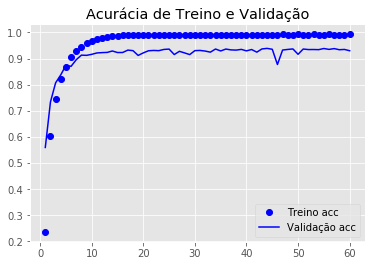

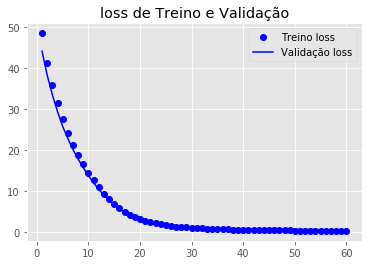

In [12]:
overfitting_plot(hist,EXP_NAME)